# Working with Annual Averages in Cal-Adapt API

In [1]:
%matplotlib inline
%matplotlib nbagg

import requests 
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
headers = {'ContentType': 'json'}

api = 'http://api.cal-adapt.org/api'

In [2]:
resource = 'counties'
geometry_uri = ''

# Point location in geojson format
lat = 38.5938
lng = -121.4687
point = '{"type":"Point","coordinates":[' + str(lng) + ',' + str(lat) + ']}'

# Params
params = {'intersects': point, 'srs': 4326, 'precision': 4}
params_str = "&".join("%s=%s" % (k,v) for k,v in params.items())

# Construct url
url = api + '/' + resource + '/' + '?' + params_str
print(url)
print()

# Get county geometry
response = requests.get(url, headers=headers)
if response.status_code == requests.codes.ok:
    data = response.json()
    geometry_uri = '/api/' + resource + '/' + str(data['features'][0]['id']) + '/'
    print ('Uniform Resource Identifier for county:' + geometry_uri)

http://api.cal-adapt.org/api/counties/?intersects={"type":"Point","coordinates":[-121.4687,38.5938]}&srs=4326&precision=4

Uniform Resource Identifier for county:/api/counties/34/


### Get a list of annual timeseries from Cal-Adapt API for maximum temperature for HadGEM2-ES model

In [3]:
resource = 'series'

# Params
search_str = 'yearly+average+maximum+temperature+HadGEM2-ES'
params = {'name': search_str, 'pagesize': 100}
params_str = "&".join("%s=%s" % (k,v) for k,v in params.items())

# Construct url for finding list of series
url = api + '/' + resource + '/' + '?' + params_str
timeseries = None

# Make request to API
response = requests.get(url, headers=headers)
if response.status_code == requests.codes.ok:
    data = response.json()
    timeseries = data['results']
    for item in timeseries:
        print(item['url'])

http://api.cal-adapt.org/api/series/tasmax_year_HadGEM2-ES_historical/
http://api.cal-adapt.org/api/series/tasmax_year_HadGEM2-ES_rcp45/
http://api.cal-adapt.org/api/series/tasmax_year_HadGEM2-ES_rcp85/


In [4]:
ts = [x for x in timeseries if (x['name'].find('8.5') > -1)]
ts_rcp85 = ts[0]

### Setup parameters for requesting data

In [5]:
# Period
startYear = 1961
endYear = 1990
period = str(startYear) + '-01-01/' + str(endYear) + '-12-31'
# Alternatively get complete timeseries and filter dates later on
period = 'rasters'

In [6]:
# Pagesize - number of records returned, default is 10
pagesize = 100

In [7]:
params = {'pagesize': pagesize, 'ref': geometry_uri}
params_str = "&".join("%s=%s" % (k,v) for k,v in params.items())

url = ts_rcp85['url'] +  period + '/?' + params_str
print(url)

http://api.cal-adapt.org/api/series/tasmax_year_HadGEM2-ES_rcp85/rasters/?pagesize=100&ref=/api/counties/34/


### Request data

In [8]:
data = None
response = requests.get(url, headers=headers)
if response.status_code == requests.codes.ok:
    json = response.json()
    data = json['results']
    print(data[0])

{'id': 12320, 'tileurl': 'http://api.cal-adapt.org/tiles/tasmax_year_HadGEM2-ES_rcp85_2006/{z}/{x}/{y}.png', 'url': 'http://api.cal-adapt.org/api/rstores/tasmax_year_HadGEM2-ES_rcp85_2006/', 'image': [[None, None, None, 297.54901123046875, 297.4054260253906, 297.38153076171875, 297.3214111328125, 297.3660888671875, 297.3605041503906, 297.50689697265625, 297.37823486328125, 297.1661682128906, 297.11669921875, None], [None, None, None, 297.4867858886719, 297.3352355957031, 297.2320251464844, 297.2207336425781, 297.1967468261719, 297.2304992675781, 297.2887268066406, 297.3641052246094, 297.3287048339844, 296.9217529296875, None], [None, None, None, None, 297.1847229003906, 297.02294921875, 297.0770568847656, 297.1314697265625, 297.1186218261719, 297.22247314453125, 297.1927185058594, 297.21893310546875, 297.28045654296875, 297.2366943359375], [None, None, None, None, 296.927734375, 296.77081298828125, 296.8077697753906, 297.1183166503906, 297.0250244140625, 296.9697265625, 297.09555053710

### Create pandas dataframe from data.

In [9]:
df = pd.DataFrame(data)
# Change format of `event` field from string to datetime
df['event'] = pd.to_datetime(df['event'], format='%Y-%m-%d')
# Set event field as index
df = df.set_index(['event'])
df.head()

,geom,height,id,image,maxval,minval,name,nodata,slug,srs,tileurl,units,url,width,xpixsize,ypixsize
event,,,,,,,,,,,,,,,,
2006-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12320,"[[None, None, None, 297.54901123046875, 297.40...",306.680267,277.294617,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2006,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625
2007-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12321,"[[None, None, None, 299.23675537109375, 299.11...",306.515289,279.461761,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2007,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625
2008-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12322,"[[None, None, None, 297.712158203125, 297.6103...",306.392303,277.135956,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2008,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625
2009-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12323,"[[None, None, None, 297.7378845214844, 297.649...",306.001038,277.822418,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2009,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625
2010-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12324,"[[None, None, None, 297.0587158203125, 296.957...",305.385651,277.153900,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2010,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625


### Filter dataframe for years 2031 - 2060

In [10]:
filtered = df.ix['2031-01-01':'2060-01-01']
filtered.head()

,geom,height,id,image,maxval,minval,name,nodata,slug,srs,tileurl,units,url,width,xpixsize,ypixsize
event,,,,,,,,,,,,,,,,
2031-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12345,"[[None, None, None, 298.5990905761719, 298.498...",307.710938,278.883209,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2031,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625
2032-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12346,"[[None, None, None, 300.0038146972656, 299.850...",308.421173,279.548584,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2032,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625
2033-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12347,"[[None, None, None, 299.12945556640625, 298.98...",306.917236,279.081390,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2033,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625
2034-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12348,"[[None, None, None, 300.33465576171875, 300.21...",308.820526,280.245483,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2034,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625
2035-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12349,"[[None, None, None, 299.3792419433594, 299.283...",308.117859,278.713013,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2035,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625


#### The `image` field contains the value for climate variable, in this case maximum temeperature. The `units` field indicates units for the data, in this case Kelvin. Calculate average temperature.

### Convert `image` field type from list to a numpy array of floats

In [11]:
df['image'] = df['image'].apply(lambda x: np.array(x, dtype=np.float))
type(df['image'].iloc[0])

numpy.ndarray

In [12]:
data_min = df['minval'].min()
data_max = df['maxval'].min()
print (data_min, data_max)

277.135955811 305.385650635


<IPython.core.display.Javascript object>


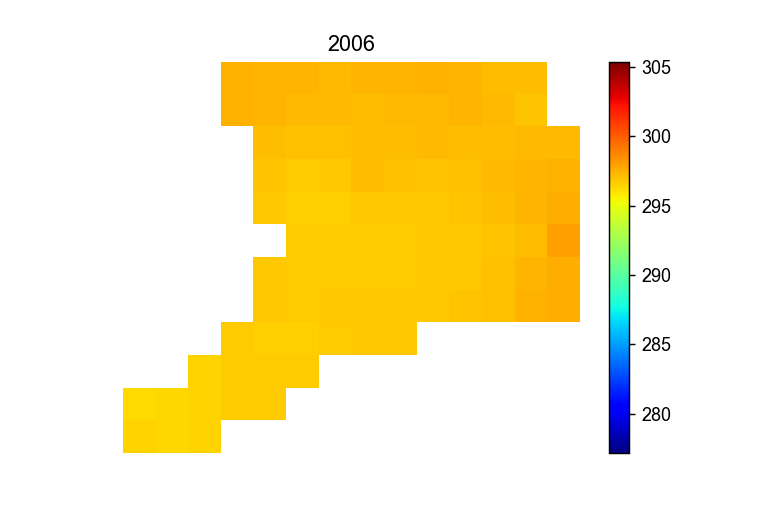

In [13]:

array = df['image'].iloc[0]
fig, ax = plt.subplots()
img = ax.imshow(array, interpolation='nearest', cmap=plt.get_cmap('jet'), vmin=data_min, vmax=data_max)
fig.colorbar(img)
plt.axis('off')
plt.title(df.index[0].year)
plt.show()

<IPython.core.display.Javascript object>


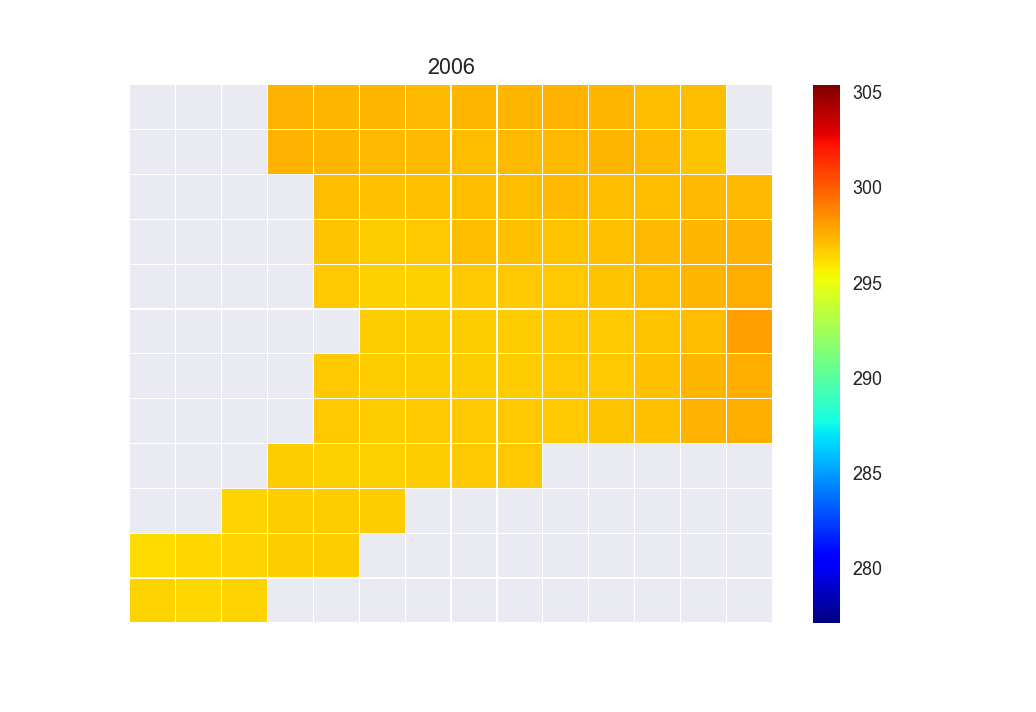

[[], []]

In [35]:
import seaborn as sns
fig = plt.figure()

heatmap_data = df['image'].iloc[0]

ax = sns.heatmap(
    heatmap_data,
    annot = False,
    vmin = data_min,
    vmax = data_max,
    cmap = 'jet',
    linewidths = 0.1,
)
ax.set_title(df.index[0].year)
ax.set(xticklabels=[], yticklabels=[])


<IPython.core.display.Javascript object>


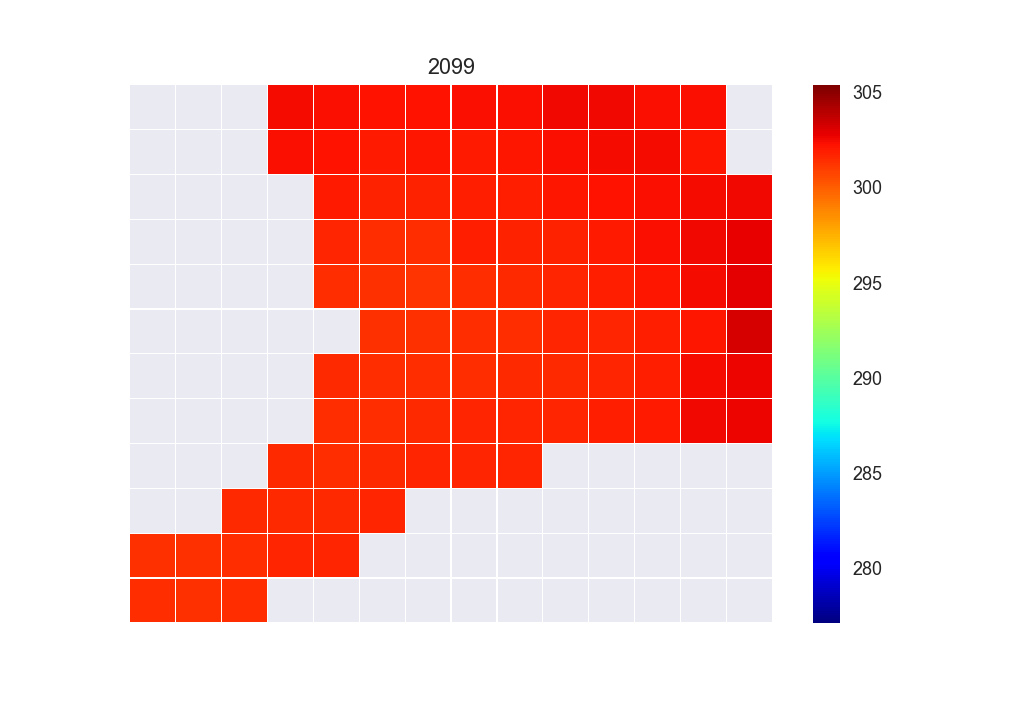

In [37]:
import matplotlib.animation as animation

# First set up the figure, the axis, and the plot element we want to animate
fig_anim = plt.figure()

def update_frame(i):
    plt.clf()
    heatmap_data = df['image'].iloc[i]
    print(i)
    ax = sns.heatmap(
        heatmap_data,
        annot = False,
        vmin = data_min,
        vmax = data_max,
        cmap = 'jet',
        linewidths = 0.1,
    )
    ax.set_title(df.index[i].year)
    ax.set(xticklabels=[], yticklabels=[])

# write animation frames
anim = animation.FuncAnimation(fig_anim, update_frame, interval=1000)
